In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers  import L2, L1
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.losses import BinaryCrossentropy
import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install opencv-python


  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/ec/6c/fab8113424af5049f85717e8e527ca3773299a3c6b02506e66436e19874f/opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB 640.0 kB/s eta 0:01:01
   ---------------------------------------- 0.1/38.8 MB 1.2 MB/s eta 0:00:33
   ---------------------------------------- 0.3/38.8 MB 2.0 MB/s eta 0:00:20
   ---------------------------------------- 0.4/38.8 MB 2.5 MB/s eta 0:00:16
    --------------------------------------- 0.7/38.8 MB 3.2 MB/s eta 0:00:12
    --------------------------------------- 0.9/38.8 MB 3.5 MB/s eta 0:00:11
   - -------------------------------------- 1.1/38.8 MB 3.8 MB/s eta 0:00:11
   - -------------------------------------- 1.5/38.8 MB 4.1 MB/s eta 0:00:10
   - -------------------------------------- 1.9/38.8 MB 4.6 MB/s eta 0:00:08
   -- -------

In [2]:
train_directory = "C:/Users/ZY LAPTOP/Desktop/dssi/prjt/archive/Training"
val_directory = "C:/Users/ZY LAPTOP/Desktop/dssi/prjt/archive/Validation"

In [3]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 48,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 30,
    "DROPOUT_RATE": 0.05,
    "REGULARIZATION_RATE": 0.001,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 2,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ['female','male']
}

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 47007 files belonging to 2 classes.


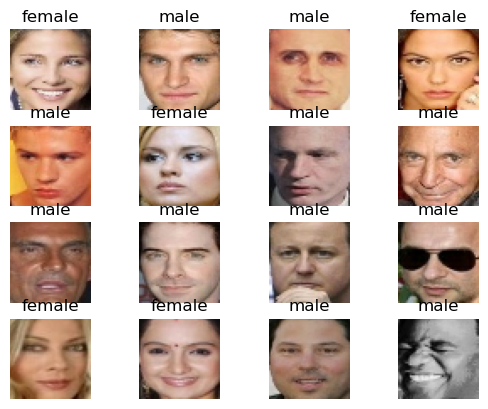

In [5]:
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

In [6]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,#CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 11649 files belonging to 2 classes.


In [7]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE))

In [8]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [9]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),                 
])

In [10]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),
    
    resize_rescale_layers,
    
    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),
    
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "sigmoid"),

])

In [11]:
lenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 46, 46, 6)      │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 6)      │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 16)     │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,639,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,776,626 (6.78 MB)

 Trainable params: 1,774,278 (6.77 MB)

 Non-trainable params: 2,348 (9.17 KB)

In [12]:
loss_function = BinaryCrossentropy()

In [13]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=4, name = "top_k_accuracy")]

In [14]:
lenet_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [16]:
history = lenet_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  batch_size= CONFIGURATION["BATCH_SIZE"],

  epochs = CONFIGURATION["N_EPOCHS"],callbacks=[early_stopping],
  verbose = 1
)

Epoch 1/30
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 196s 128ms/step - accuracy: 0.8787 - loss: 1.0858 - top_k_accuracy: 1.0000 - val_accuracy: 0.9101 - val_loss: 0.3944 - val_top_k_accuracy: 1.0000
Epoch 2/30
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 174s 118ms/step - accuracy: 0.9236 - loss: 0.3601 - top_k_accuracy: 1.0000 - val_accuracy: 0.9217 - val_loss: 0.3326 - val_top_k_accuracy: 1.0000
Epoch 3/30
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 214s 145ms/step - accuracy: 0.9316 - loss: 0.3292 - top_k_accuracy: 1.0000 - val_accuracy: 0.9308 - val_loss: 0.3363 - val_top_k_accuracy: 1.0000
Epoch 4/30
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 218s 148ms/step - accuracy: 0.9379 - loss: 0.3109 - top_k_accuracy: 1.0000 - val_accuracy: 0.9524 - val_loss: 0.2493 - val_top_k_accuracy: 1.0000
Epoch 5/30
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 166s 113ms/step - accuracy: 0.9413 - loss: 0.2812 - top_k_accuracy: 1.0000 - val_accuracy: 0.9248 - val_loss: 0.3060 - val_top_k_accuracy: 1.0000
Epoch 6/30
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 184s 126ms/step - 

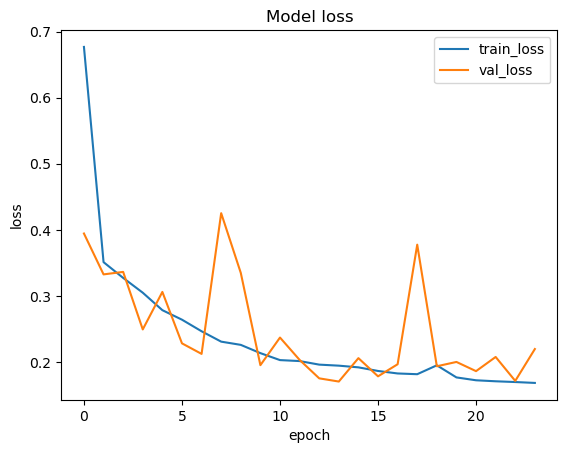

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

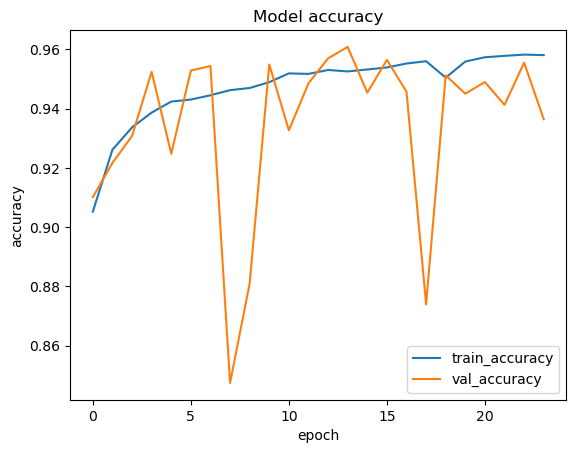

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [28]:

lenet_model.save('gender_classification.keras')


In [29]:
from tensorflow.keras.models import load_model
model = load_model('gender_classification.keras')


In [21]:
img_path='C:/Users/ZY LAPTOP/Desktop/Mohamed/me/nad.jpg'

In [31]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import numpy as np

# Charger le modèle

model = load_model('gender_classification.keras')
# Charger une image à prédire
image_path = 'C:/Users/ZY LAPTOP/Desktop/Mohamed/me/nad.jpg'
img = load_img(image_path, target_size=(64, 64))  # Modifier la taille selon les besoins du modèle

# Convertir l'image en tableau numpy
img_array = img_to_array(img)

# Ajouter une dimension pour le batch (pour qu'il corresponde à l'entrée du modèle)
img_array = np.expand_dims(img_array, axis=0)

# Normaliser l'image si nécessaire (si ton modèle le nécessite)
img_array = img_array / 255.0  # Normalisation entre 0 et 1

# Faire la prédiction
prediction = model.predict(img_array)

# Afficher les probabilités de chaque classe
male_prob = prediction[0][0]
female_prob = 1 - male_prob  # Puisque c'est une classification binaire

print(f"Probabilité pour Male : {male_prob}")
print(f"Probabilité pour Female : {female_prob}")

# Prédiction binaire

if male_prob > 0.5:
    print("Prédiction : Male")
else:
    print("Prédiction : Female")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Probabilité pour Male : 0.09410540014505386
Probabilité pour Female : 0.9058945998549461
Prédiction : Female
